In [38]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2


In [39]:
SEQLEN = 30
import os
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

img_base_path = '/home/hyun/focussu-ai/data/01_OriginData'
meta_base_path = '/home/hyun/focussu-ai/data/02_LabeledData'

In [40]:
test_meta = json.load(open('/home/hyun/focussu-ai/data/02_LabeledData/TL_60_01/02-05-83--1-60-23101000000010-01-1.json'))

In [41]:
for k in test_meta['이미지'].items():
    print(k)

('filename', '02-05-83--1-60-23101000000010-01.mp4')
('date', '2023.10.10')
('format', '02-05-83--1-60-23101000000010-01-1.jpg')
('category', {'id': 1, 'name': '집중'})
('emotion', '흥미로움')
('gender', 1)
('birth', 60)
('education', '한국기술교육대학교 능력개발교육원')
('grade', '99')
('subject', '수학')
('method', '개인/집단 혼형')
('place', '오프라인')
('student_type', '적용형')
('student_thou', '총체적')
('student_char', '사회지향')
('student_act', '감성')
('ignition_type', None)
('content_type', '끌리는 브랜드의 법칙1')
('timeline', {'id': 1, 'start': '00:00:10', 'end': '00:00:20'})
('imgsize(MB)', 0.141)
('width', 1080)
('height', 720)
('face_box', [[457, 157], [716, 414]])
('face_points', [[585, 313], [586, 294], [586, 253], [586, 213], [586, 323], [586, 344], [586, 358], [507, 210], [568, 311], [551, 315], [540, 319], [529, 327], [490, 167], [530, 158], [479, 179], [570, 323], [543, 345], [570, 293], [550, 288], [507, 159], [558, 160], [557, 214], [499, 373], [459, 271], [521, 215], [516, 388], [586, 414], [539, 216], [537, 206], 

# 01. Data Loader

In [42]:
class FocusDataset(Dataset):
    def __init__(self, img_dir, meta_dir, SEQLEN):
        self.img_dir = img_dir
        self.meta_dir = meta_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.sequence_length = SEQLEN
        
    def __len__(self):
        return len(self.img_files) // self.sequence_length
        
    def __getitem__(self, idx):
        sequence = []
        metadata_sequence = []
        start_idx = idx * self.sequence_length
        
        for i in range(self.sequence_length):
            # 이미지 로드
            img_path = os.path.join(self.img_dir, self.img_files[start_idx + i])
            image = Image.open(img_path)
            image = torch.FloatTensor(np.array(image))
            sequence.append(image)
            
            # 메타데이터 로드
            json_filename = os.path.splitext(self.img_files[start_idx + i])[0] + '.json'
            json_path = os.path.join(self.meta_dir, json_filename)
            
            try:
                with open(json_path, 'r') as f:
                    metadata = json.load(f)
                    meta_dict = {
                        'category_id': metadata['이미지']['category']['id'],
                        'category_name': metadata['이미지']['category']['name'],
                        'emotion': metadata['이미지']['emotion']
                    }
                    
                metadata_sequence.append(meta_dict)
            except FileNotFoundError:
                print(f"Warning: Metadata file not found for {json_filename}")
                metadata_sequence.append({})
            
        # 시퀀스를 하나의 텐서로 스택
        sequence = torch.stack(sequence)
        return sequence, metadata_sequence

# 데이터셋 및 데이터로더 생성
dataset = FocusDataset(
    os.path.join(img_base_path, 'TS_60_01'),
    os.path.join(meta_base_path, 'TL_60_01'),
    SEQLEN
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

배치 크기: torch.Size([4, 30, 720, 1080, 3])
메타데이터 배치 크기: 30


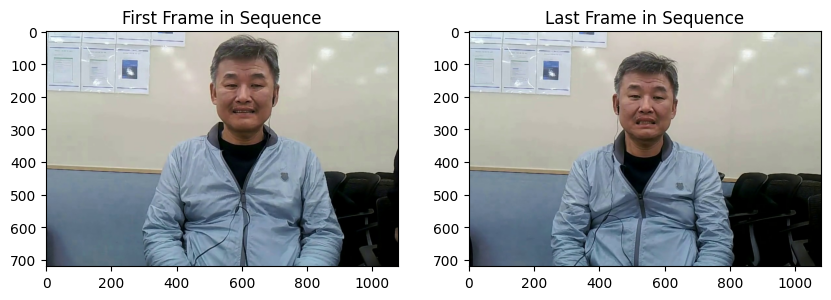

시퀀스의 최소값: 0.0
시퀀스의 최대값: 255.0
첫 번째 프레임의 메타데이터: {'category_id': tensor([1, 1, 1, 1]), 'category_name': ['집중', '집중', '집중', '집중'], 'emotion': ['흥미로움', '흥미로움', '흥미로움', '흥미로움']}


In [43]:
# 데이터로더 테스트
for batch, metadata_batch in dataloader:
    print(f"배치 크기: {batch.shape}")
    print(f"메타데이터 배치 크기: {len(metadata_batch)}")
    
    # 첫 번째 시퀀스의 첫 번째 프레임 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(batch[0][0].numpy().astype(np.uint8))
    plt.title("First Frame in Sequence")
    
    # 첫 번째 시퀀스의 마지막 프레임 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(batch[0][-1].numpy().astype(np.uint8))
    plt.title("Last Frame in Sequence")
    
    plt.show()
    print("시퀀스의 최소값:", batch.min().item())
    print("시퀀스의 최대값:", batch.max().item())
    print("첫 번째 프레임의 메타데이터:", metadata_batch[0])
    break

# 02. Face Landmark

In [44]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [45]:
model_path = "/home/hyun/focussu-ai/model/face_landmarker.task"


I0000 00:00:1746686667.945868   92972 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1746686667.946310   92972 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1746686667.951638   94825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746686667.961731   94827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


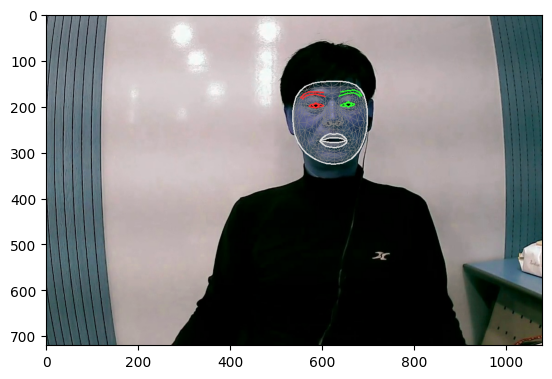

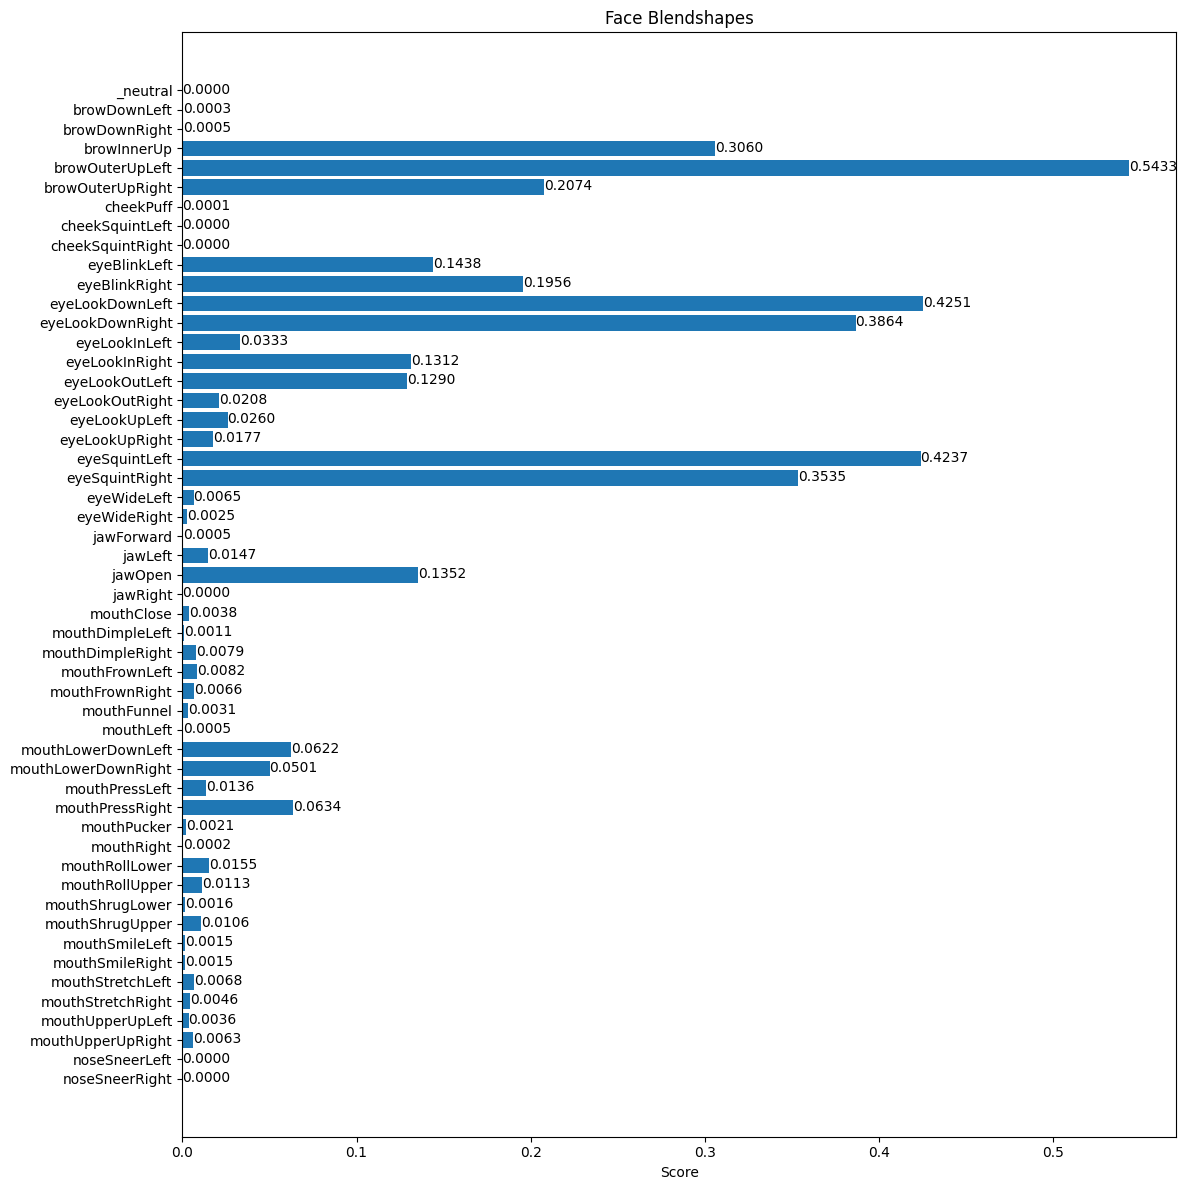

In [54]:
# face landmark in dataloader

for batch, metadata_batch in dataloader:
    # STEP 2: Create an FaceLandmarker object.
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)
    detector = vision.FaceLandmarker.create_from_options(options)

    # STEP 3: Load the input image.
    image = batch[0][0].numpy().astype(np.uint8)
    
    # STEP 4: Detect face landmarks from the input image.
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    detection_result = detector.detect(mp_image)
    
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))    
    plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
    break

# 03. Train Classifier
### TODO
- 입력 format 정의
- model 정의

# 04. Train
학습

# 05. Validation & Test 